<a href="https://colab.research.google.com/github/FirmanAhmadBayumi/Deep-Learning/blob/main/2117051062_UAS_Augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 15.1 MB/s eta 0:00:00


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the base directory where all images are stored
BASE_DIR = '/content/drive/MyDrive/Computer Vision/Augmented'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

class_names = os.listdir(train_dir)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMG_SIZE = (224, 224)

In [5]:
def load_data(directory):
    images = []
    labels = []

    for folder in os.listdir(directory):
        if folder in class_names:
            label = class_names.index(folder)

            for file in os.listdir(os.path.join(directory, folder)):
                img_path = os.path.join(os.path.join(directory, folder), file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                    image = cv2.imread(img_path)

                    if image is not None:
                        image = cv2.resize(image, IMG_SIZE)
                        images.append(image)
                        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    # Shuffle the data using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=25)

    return images, labels

In [6]:
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [8]:
def display_examples(class_names, images, labels):
    figsize = (20, 20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Contoh Sampel Dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
    plt.show()

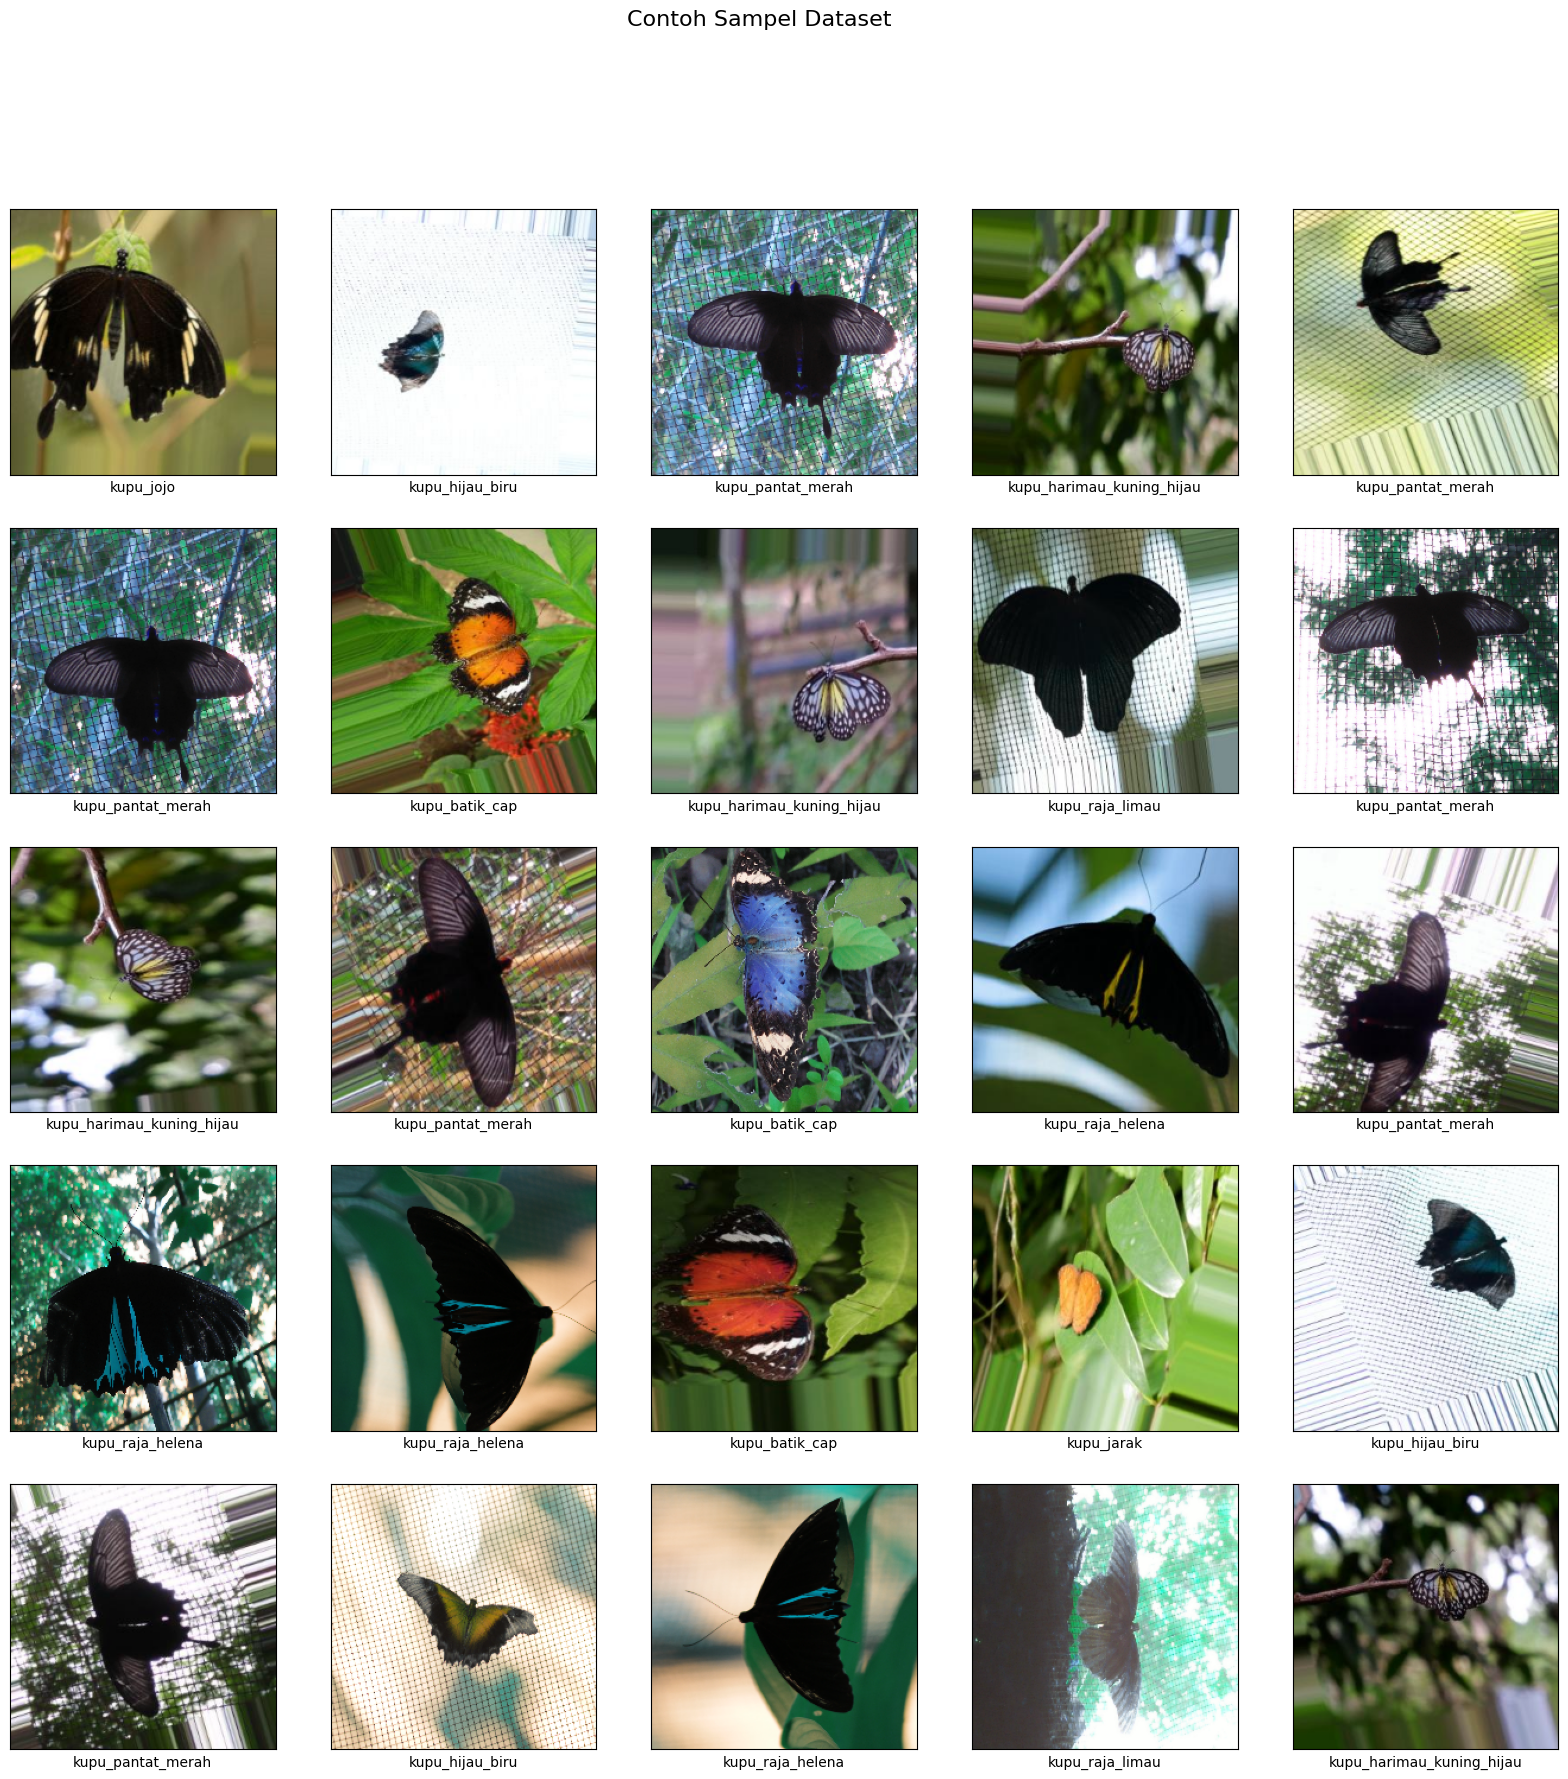

In [9]:
display_examples(class_names, train_images, train_labels)

In [10]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

In [11]:
train_dataset = train_data.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=32,
                                               class_mode='sparse')

validation_dataset = validation_data.flow_from_directory(val_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=32,
                                                         class_mode='sparse')

test_dataset = validation_data.flow_from_directory(test_dir,
                                                   target_size=IMG_SIZE,
                                                   batch_size=32,
                                                   class_mode='sparse')

Found 1657 images belonging to 8 classes.
Found 240 images belonging to 8 classes.
Found 477 images belonging to 8 classes.


In [12]:
# Preprocess the images for InceptionV3 and Xception
train_images = tf.keras.applications.inception_v3.preprocess_input(train_images)
test_images = tf.keras.applications.inception_v3.preprocess_input(test_images)

In [13]:
# Membangun model dengan Xception base
def build_model_xception(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Membangun model dengan InceptionV3 base
def build_model_inceptionv3(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Membangun model dengan Inceptionv4 base
def build_model_inceptionv4(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(train_dataset.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [14]:
# Xception
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_xception = build_model_xception(base_model_xception)

# InceptionV3
base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_inceptionv3 = build_model_inceptionv3(base_model_inceptionv3)

# InceptionV4
base_model_inceptionv4 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_inceptionv4 = build_model_inceptionv4(base_model_inceptionv4)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
# Compile the models with adjusted learning rate
model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_inceptionv3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_inceptionv4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Penyesuaian Learning Rate dan Early Stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
# Train the models
xception_history = model_xception.fit(
    train_images, train_labels, batch_size=32,
    epochs=25,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping])

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7742 - loss: 0.7194 - val_accuracy: 0.2348 - val_loss: 104.9322 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 67s 473ms/step - accuracy: 0.9782 - loss: 0.0824 - val_accuracy: 0.7925 - val_loss: 3.4570 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9831 - loss: 0.1068 - val_accuracy: 0.6038 - val_loss: 21.5673 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.9839 - loss: 0.0777 - val_accuracy: 0.2138 - val_loss: 185.0227 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - accuracy: 0.9549 - loss: 0.3214 - val_accuracy: 0.2956 - val_loss: 63.3040 - learning_rate: 0.0010
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 486ms/step - accuracy: 0.9718 - loss: 0.1891 - val_accuracy: 0.7862 - val_loss: 5.3838 - learning_rate: 2.0000e-04
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - accuracy: 0.9870 - 

In [ ]:
# Train the models
inceptionv3_history = model_inceptionv3.fit(
    train_images, train_labels, batch_size=64,
    epochs=25,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping])

In [19]:
# Train the models
inceptionv4_history = model_inceptionv4.fit(
    train_images, train_labels, batch_size=64,
    epochs=25,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping])

Epoch 1/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.7796 - loss: 0.7430 - val_accuracy: 0.1971 - val_loss: 1481.4808 - learning_rate: 0.0010
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 0.9125 - loss: 0.4062 - val_accuracy: 0.9350 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step - accuracy: 0.9221 - loss: 0.2434 - val_accuracy: 0.8134 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 317ms/step - accuracy: 0.9770 - loss: 0.0645 - val_accuracy: 0.9790 - val_loss: 0.1318 - learning_rate: 0.0010
Epoch 5/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - accuracy: 0.9925 - loss: 0.0296 - val_accuracy: 0.9644 - val_loss: 0.1226 - learning_rate: 0.0010


In [20]:
def plot_accuracy_loss_multiple(histories, model_names):
    num_models = len(histories)
    fig, axes = plt.subplots(num_models, 2, figsize=(12, 4 * num_models))

    for i, (history, model_name) in enumerate(zip(histories, model_names)):
        # Jika hanya satu model, axes adalah 1D array
        if num_models == 1:
            acc_ax = axes[0]
            loss_ax = axes[1]
        else:
            acc_ax = axes[i, 0]
            loss_ax = axes[i, 1]

        # Akurasi
        acc_ax.plot(history.history['accuracy'], label='Train Accuracy')
        acc_ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        acc_ax.set_title(f'{model_name} Training & Validation Accuracy')
        acc_ax.set_xlabel('Epochs')
        acc_ax.set_ylabel('Accuracy')
        acc_ax.legend()

        # Loss
        loss_ax.plot(history.history['loss'], label='Train Loss')
        loss_ax.plot(history.history['val_loss'], label='Validation Loss')
        loss_ax.set_title(f'{model_name} Training & Validation Loss')
        loss_ax.set_xlabel('Epochs')
        loss_ax.set_ylabel('Loss')
        loss_ax.legend()

    plt.tight_layout()
    plt.show()

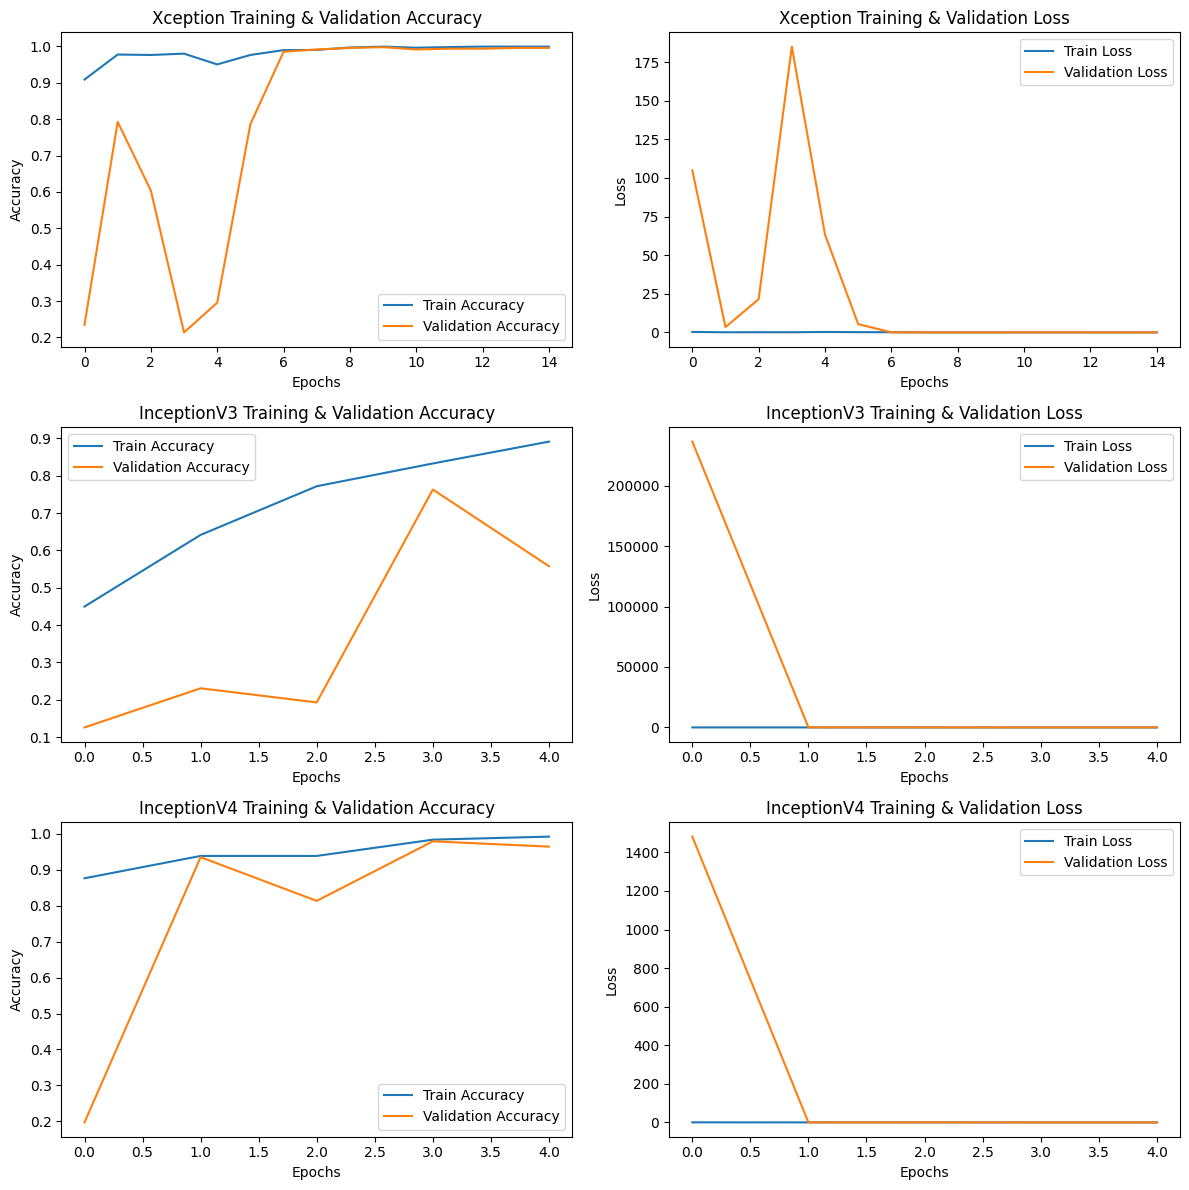

In [21]:
histories = [xception_history, inceptionv3_history, inceptionv4_history]
model_names = ['Xception', 'InceptionV3', 'InceptionV4']

plot_accuracy_loss_multiple(histories, model_names)

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrices(models, test_images, test_labels, class_names):
    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6))

    for i, (model, model_name) in enumerate(models):
        # Prediksi model
        predictions = model.predict(test_images)
        predicted_labels = np.argmax(predictions, axis=1)

        # Hitung Confusion Matrix
        conf_matrix = confusion_matrix(test_labels, predicted_labels)

        # Plot Confusion Matrix
        ax = axes[i] if num_models > 1 else axes  # Jika hanya satu model
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_title(f'Confusion Matrix - {model_name}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

    plt.tight_layout()
    plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


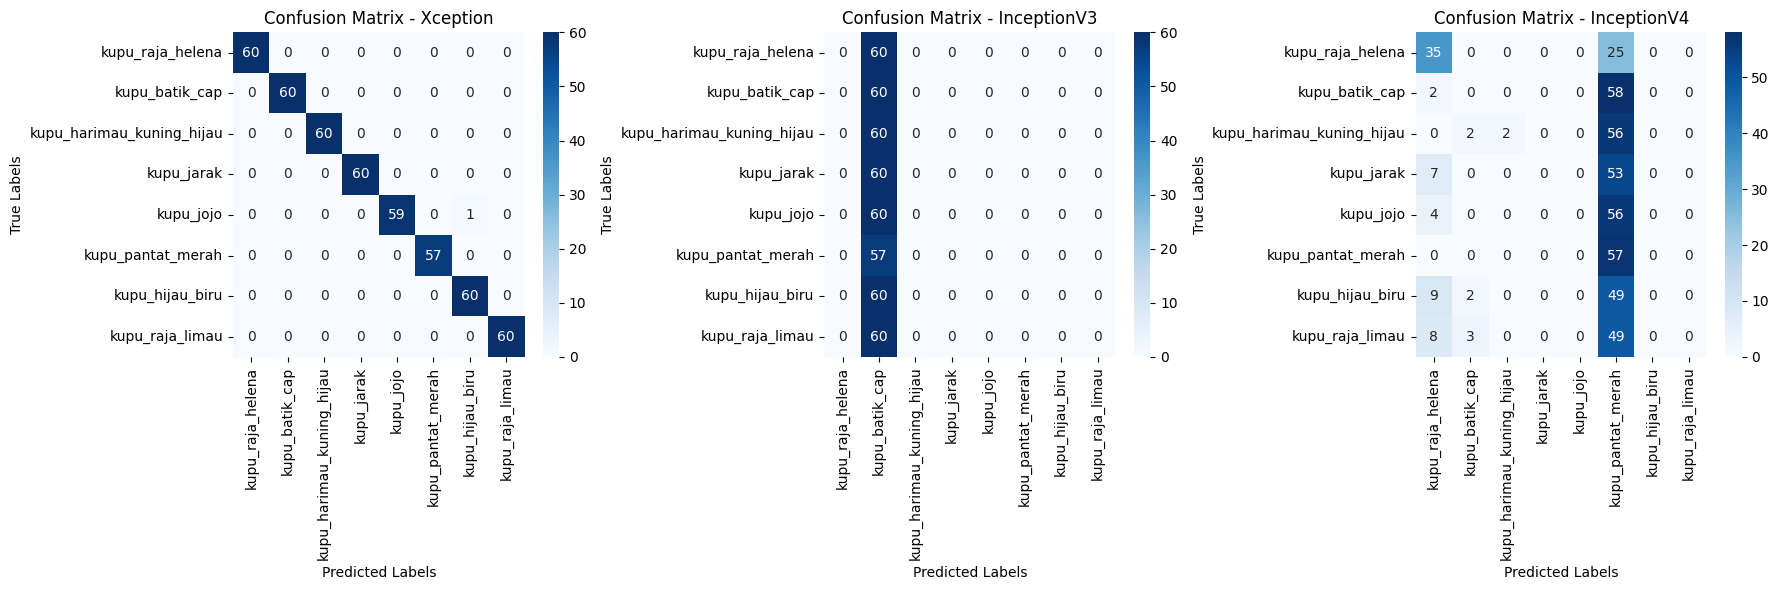

In [23]:
models = [
    (model_xception, 'Xception'),
    (model_inceptionv3, 'InceptionV3'),
    (model_inceptionv4, 'InceptionV4')
]

plot_confusion_matrices(models, test_images, test_labels, class_names)

In [24]:
# Fungsi untuk memprediksi gambar yang diunggah menggunakan model yang sudah dilatih
def predict_uploaded_images(image_paths, model):
    predictions_list = []
    for image_path in image_paths:
        # Load and preprocess the image
        img = Image.open(image_path)
        img = img.resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Perform prediction
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = np.max(predictions[0]) * 100

        predictions_list.append((predicted_class, confidence))

    return predictions_list

In [25]:
# Fungsi untuk menampilkan gambar yang diunggah
def display_uploaded_images(image_paths):
    fig = plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths, start=1):
        img = Image.open(image_path)
        plt.subplot(1, len(image_paths), i)
        plt.imshow(img)
        plt.axis('off')

        # Extract class name from image file name
        class_name = os.path.splitext(os.path.basename(image_path))[0]
        plt.title(class_name)
    plt.show()

In [26]:
# Definisikan direktori dasar dan memuat gambar yang diunggah
BASE_DIR = '/content/drive/MyDrive/Computer Vision/data_testing'
uploaded_image_filenames = os.listdir(BASE_DIR)
uploaded_image_paths = [os.path.join(BASE_DIR, filename) for filename in uploaded_image_filenames]

In [27]:
# Melakukan prediksi menggunakan model yang sudah dilatih
xception_predictions = predict_uploaded_images(uploaded_image_paths, model_xception)
inceptionv3_predictions = predict_uploaded_images(uploaded_image_paths, model_inceptionv3)
inceptionv4_predictions = predict_uploaded_images(uploaded_image_paths, model_inceptionv4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


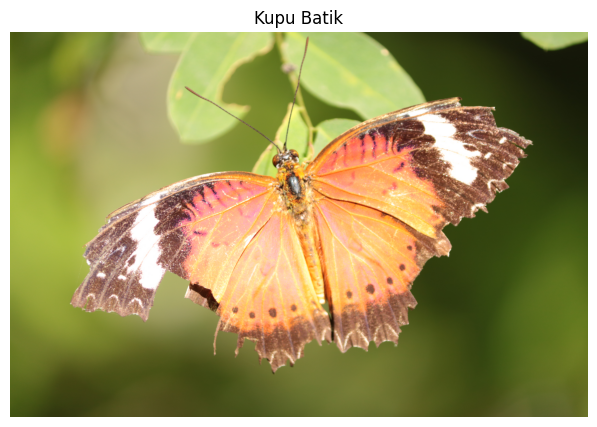

Image: Kupu Batik
Xception Prediction: kupu_batik_cap
Xception Confidence: 90.28%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_pantat_merah
InceptionV4 Confidence: 100.00%



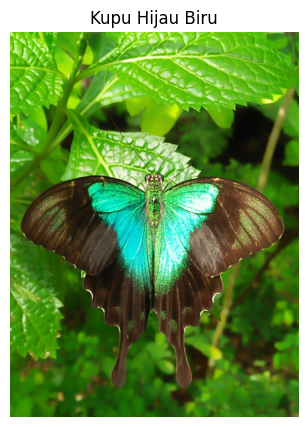

Image: Kupu Hijau Biru
Xception Prediction: kupu_hijau_biru
Xception Confidence: 100.00%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_pantat_merah
InceptionV4 Confidence: 100.00%



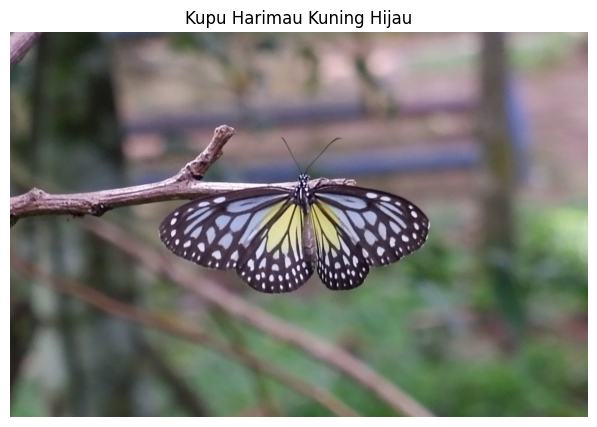

Image: Kupu Harimau Kuning Hijau
Xception Prediction: kupu_harimau_kuning_hijau
Xception Confidence: 99.81%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_batik_cap
InceptionV4 Confidence: 99.76%



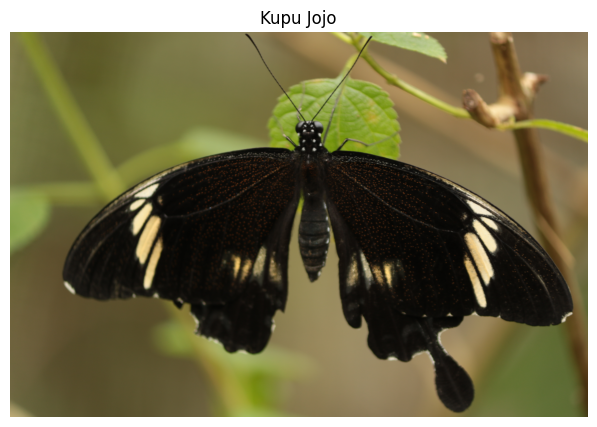

Image: Kupu Jojo
Xception Prediction: kupu_jojo
Xception Confidence: 100.00%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_pantat_merah
InceptionV4 Confidence: 100.00%



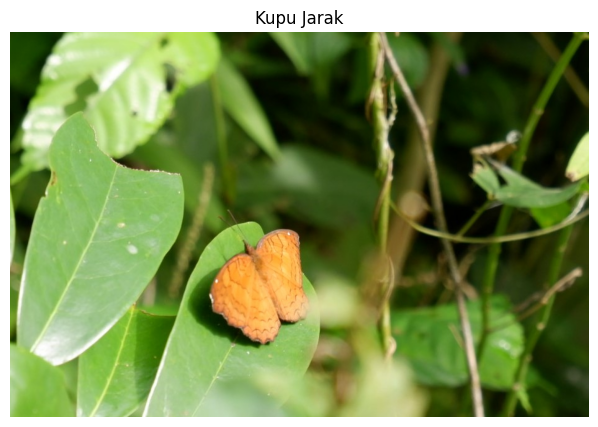

Image: Kupu Jarak
Xception Prediction: kupu_jarak
Xception Confidence: 99.96%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_pantat_merah
InceptionV4 Confidence: 100.00%



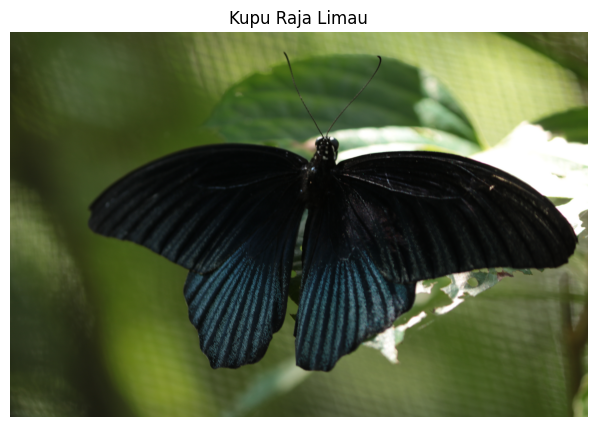

Image: Kupu Raja Limau
Xception Prediction: kupu_raja_limau
Xception Confidence: 99.97%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_pantat_merah
InceptionV4 Confidence: 100.00%



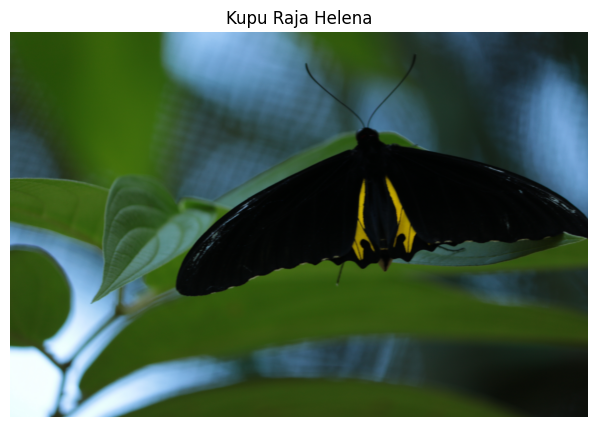

Image: Kupu Raja Helena
Xception Prediction: kupu_raja_helena
Xception Confidence: 99.56%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_raja_helena
InceptionV4 Confidence: 100.00%



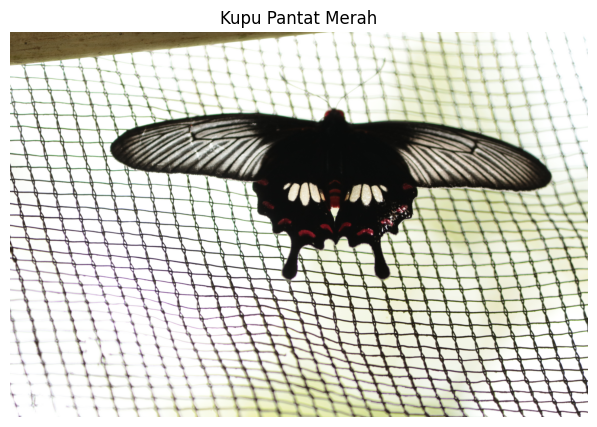

Image: Kupu Pantat Merah
Xception Prediction: kupu_pantat_merah
Xception Confidence: 100.00%
InceptionV3 Prediction: kupu_batik_cap
InceptionV3 Confidence: 100.00%
InceptionV4 Prediction: kupu_pantat_merah
InceptionV4 Confidence: 100.00%



In [28]:
# Menampilkan hasil prediksi
for i, image_path in enumerate(uploaded_image_paths, start=1):
    display_uploaded_images([image_path])
    print("Image:", os.path.splitext(os.path.basename(image_path))[0])
    print("Xception Prediction:", xception_predictions[i-1][0])
    print("Xception Confidence: {:.2f}%".format(xception_predictions[i-1][1]))
    print("InceptionV3 Prediction:", inceptionv3_predictions[i-1][0])
    print("InceptionV3 Confidence: {:.2f}%".format(inceptionv3_predictions[i-1][1]))
    print("InceptionV4 Prediction:", inceptionv4_predictions[i-1][0])
    print("InceptionV4 Confidence: {:.2f}%".format(inceptionv4_predictions[i-1][1]))
    print()